<a href="https://colab.research.google.com/github/eladses/sudoku-solver/blob/main/sudoku_solver_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**in development!! not done**

sudoku solver using openCV, pytesseract and py-sudoku to find solution of sudoku from image

---

**How To Use**

1. upload image
2. run imports
3. run functions
4. run algorethms

---

**How It Works**

1. extraction board
  1. finding biggest square
  2.
2. filtering cells
  1.
  2.


# Imports

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install py-sudoku
!pip install opencv-python

In [ ]:
import numpy as np
import cv2
import math

from imutils import contours
from google.colab.patches import cv2_imshow

from sudoku import Sudoku

from PIL import Image
import requests

import pytesseract
# pytesseract.pytesseract.tesseract_cmd = (
#     r'/usr/bin/tesseract'
# )

from tensorflow import keras
import matplotlib.pyplot as plt

from collections import Counter

# Upload

In [ ]:
sudoku_url = 'https://i.redd.it/y4f37ifec7aa1.jpg'
img = np.array(Image.open(requests.get(sudoku_url, stream=True).raw))[:, :, ::-1].copy()

In [ ]:
cv2_imshow(img)

# computer vision functions

In [ ]:
def order_points(pts):
  """Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left

  Args:
    pts (list) - list of four points (x,y)

  Returns:
    pts (list) - rearanged list of four points (x,y) by order
  """
  rect = np.zeros((4, 2), dtype='float32')
  pts = np.array(pts)
  s = pts.sum(axis=1)

  rect[0] = pts[np.argmin(s)] # Top-left point will have the smallest sum.
  rect[2] = pts[np.argmax(s)] # Bottom-right point will have the largest sum.

  diff = np.diff(pts, axis=1)

  rect[3] = pts[np.argmin(diff)] # Top-right point will have the smallest difference.
  rect[1] = pts[np.argmax(diff)] # Bottom-left will have the largest difference.
  return rect.astype('int').tolist()


def get_board(img):
  """corpes the board from image

  Args:
    img (cv2 image format) - the image of the sudocu

  Returns:
    board_img (cv2 image format) - the board corped for the image
  """
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
  ret,thresh = cv2.threshold(gray,100,255,cv2.THRESH_BINARY_INV)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

  # find the biggest countour
  if len(contours) != 0:
      c = max(contours, key = cv2.contourArea)
      epsilon = 0.1 * cv2.arcLength(c, True)
      corners = cv2.approxPolyDP(c, epsilon, True)

  # reorder board points
  pt_A,pt_B,pt_C,pt_D=order_points([corners[0][0],corners[1][0],corners[2][0],corners[3][0]])

  # extract board
  width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
  width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
  maxWidth = max(int(width_AD), int(width_BC))

  height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
  height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
  maxHeight = max(int(height_AB), int(height_CD))

  input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
  output_pts = np.float32([[0, 0],
                          [0, maxHeight - 1],
                          [maxWidth - 1, maxHeight - 1],
                          [maxWidth - 1, 0]])

  # Getting the homography.
  M = cv2.getPerspectiveTransform(input_pts,output_pts)

  return cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR),[pt_A,pt_D,pt_C,pt_B]

In [ ]:
def remove_small_contours(img,small_area=1000):
  """this founction remove small countours from the image. used to remove the numbers

  Args:
    img (cv2 image format)

  Returns:
    img (cv2 image format)
  """

  mask = np.zeros(img.shape[:2], dtype=img.dtype)
  cnts, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:
      area = cv2.contourArea(c)
      if area < small_area:
        x, y, w, h = cv2.boundingRect(c)
        cv2.drawContours(mask, [c], 0, (255), -1)

  return img-mask


def get_cells(board_img,board_lines_mask):
    """corpes the cells from the board

    Args:
      board_img (cv2 image format) - board
      board_lines_mask (cv2 image format) - board lines

    Returns:
      board_img (cv2 image format) - the board corped for the image
    """

    invert = 255 - board_lines_mask
    cnts,_ = cv2.findContours(invert, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    newBoard = board.copy()
    rectangles=[]
    for c in cnts:
      if(cv2.contourArea(c)<0**2): continue
      x,y,w,h = cv2.boundingRect(c)
      if(w<board_img.shape[0]/18 or h<board_img.shape[1]/18): continue
      rectangles.append(cv2.boundingRect(c))

    a,b,_=board_img.shape
    rectangles = sorted(rectangles, key=lambda x: int((int((x[1])/int(a/18))+1)/2) * 100 + int((int((x[0])/int(b/18))+1)/2))

    if len(rectangles)!=81:
      return

    return rectangles




In [ ]:
def most_frequent_number(arr):
  """get the most frequent number in array

  Args:
    arr (list)

  Returns:
    number (int) - the most frequent number in array
  """
  count = Counter(arr)
  # Find the most common element
  most_common = count.most_common(1)[0][0]
  return most_common


def get_cell_content(cell):
  """get the cell content from the image with OCR

  Args:
    cell (cv2 image) - an image with a single digit

  Returns:
    number (int) - the digit in the cell
  """
  cell_copy = cell.copy()
  gray = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray,(9,9),0)
  ret,thresh1 = cv2.threshold(blur,120,255,cv2.THRESH_BINARY_INV)
  contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)
  if(len(contours)==0): return None
  # remove none number contours
  is_contain_something = False
  max_contour = max(contours, key=cv2.contourArea)
  for cnt in contours:
    if(cv2.contourArea(cnt)<cell_copy.shape[0]*cell_copy.shape[0]/30):
      cv2.fillPoly(thresh1, pts = [cnt], color=(0,0,0))
      continue
    else:
      is_contain_something = True
  if not is_contain_something: return None

  # get number boundings
  x, y, w, h = cv2.boundingRect(max_contour)

  # Cropping the text block for giving input to OCR
  cropped = (255-thresh1)[y:y + h, x:x + w]

  # Apply OCR on the images
  imgs = [cell,gray,blur,255-thresh1,cropped]

  # custom config for OCR
  custom_config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=123456789'

  # predictions of OCR
  predicts = []
  for im in imgs:
    pred = pytesseract.image_to_string(im, config = custom_config).strip()
    if len(pred) != 0:
      predicts.append(int(pred))
  if len(predicts) == 0: return 9
  return int(most_frequent_number(predicts))

In [ ]:
def put_solution_on_board(board, rectangles, puzzle_board):
  """get the cell content from the image with OCR

  Args:
    cell (cv2 image) - an image with a single digit

  Returns:
    number (int) - the digit in the cell
  """
  board_solved=board.copy()
  for i in range(len(rectangles)):
    x,y,w,h=rectangles[i]
    if (puzzle_board[i]!=None):
      cv2.putText(board_solved, str(sudoku_solution_board[i]), (x,y+20),cv2.FONT_HERSHEY_SIMPLEX,1 ,(0,255,0),2 ,cv2.LINE_AA)
    else:
      cv2.putText(board_solved, str(sudoku_solution_board[i]), (x + int(w/3), y + int(2*h/3)),cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,255) ,3 ,cv2.LINE_AA)
  return board_solved

In [ ]:
def put_board_on_image(img, board_points_on_image, board):
  """get the cell content from the image with OCR

  Args:
    cell (cv2 image) - an image with a single digit

  Returns:
    number (int) - the digit in the cell
  """
  dst_points = np.array(board_points_on_image, dtype=np.float32)

  img_solved = img.copy()
  # Define the points on the small image (source points)
  h, w, _ = board.shape
  src_points = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)

  # Calculate the perspective transformation matrix
  M = cv2.getPerspectiveTransform(src_points, dst_points)

  # Apply the perspective transformation to the small image
  warped_img = cv2.warpPerspective(board, M, (img_solved.shape[1], img_solved.shape[0]))

  # Create a mask of the warped image to overlay
  mask = np.zeros_like(img_solved, dtype=np.uint8)
  cv2.fillConvexPoly(mask, dst_points.astype(int), (255, 255, 255))

  # Invert the mask to create a region of interest (ROI)
  mask_inv = cv2.bitwise_not(mask)

  # Black-out the area of the small image in the large image
  large_img_bg = cv2.bitwise_and(img_solved, mask_inv)

  # Take only region of the warped image
  small_img_fg = cv2.bitwise_and(warped_img, mask)

  # Add the large image background and the small image foreground
  result = cv2.add(large_img_bg, small_img_fg)

  return result

# sudoku functions

In [ ]:
puzzle = Sudoku(3).difficulty(0.5)
def load_sudoku(board):
  [board[i:i+9] for i in range(0, len(board), 9)]
  return Sudoku(3, 3, board=board)
def solve_sudoku(sudoku):
  return sudoku.solve()

In [ ]:
game = load_sudoku(puzzle.board)
print(game.board)
print(solve_sudoku(game).board)
print(solve_sudoku(game))

# Program

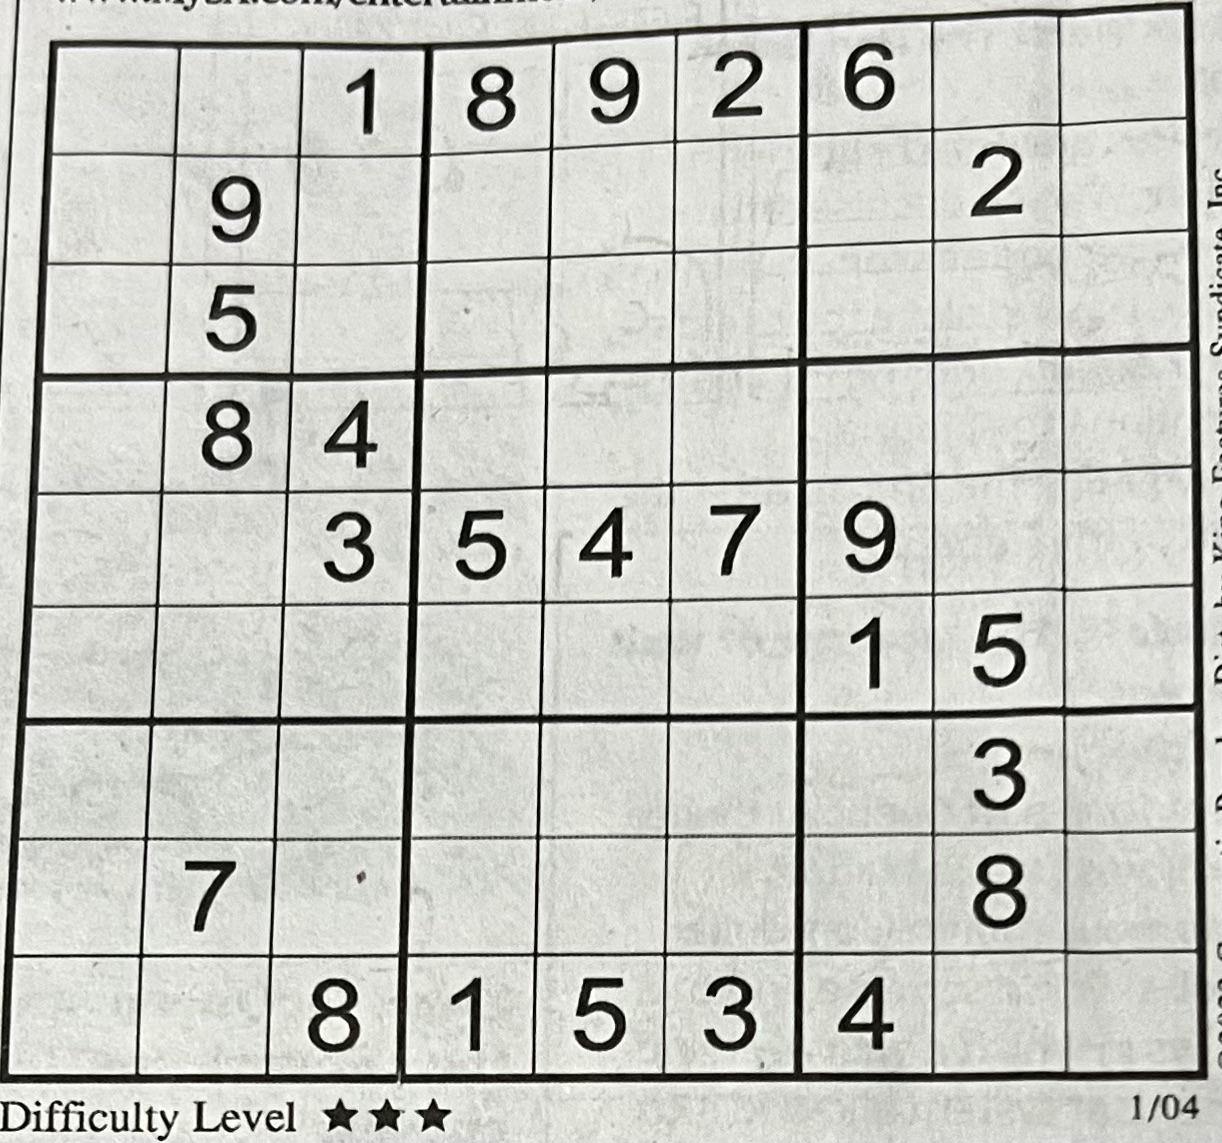

In [44]:
# show image
cv2_imshow(img)

In [ ]:
# crop board
board, board_points_on_image=get_board(img)
board = cv2.resize(board, (1200, 1200), interpolation = cv2.INTER_LINEAR)
cv2_imshow(board)
print(board.shape)

In [ ]:
# get board lines
board_gray = cv2.cvtColor(board, cv2.COLOR_RGB2GRAY)
_,board_thresh = cv2.threshold(board_gray,100,255,cv2.THRESH_BINARY_INV)
kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(board_thresh, kernel, iterations=1)
board_clean = remove_small_contours(dilated_mask,board_thresh.shape[0]*board_thresh.shape[1]/9)

cv2_imshow(board_clean)

In [ ]:
rectangles=get_cells(board,dilated_mask)

cells=[board[y:y+ h,x:x + w] for (x,y,w,h) in rectangles]

# show img of cell numbering
board_copy=board.copy()
for i in range(9):
  cv2.line(board_copy,(0,int(board_copy.shape[0]/9*i+board_copy.shape[0]/18)),(board_copy.shape[1],int(board_copy.shape[0]/9*i+board_copy.shape[0]/18)),(0,0,255),3)
  cv2.line(board_copy,(int(board_copy.shape[1]/9*i+board_copy.shape[1]/18),0),(int(board_copy.shape[1]/9*i+board_copy.shape[1]/18),board_copy.shape[0]),(0,0,255),3)
i=0
for c in rectangles:
  x,y,w,h=c
  cv2.rectangle(board_copy, (x, y), (x + w, y + h), (255,0,0), 1)
  cv2.putText(board_copy, str(i), (x,y+20),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2,cv2.LINE_AA)
  i+=1
cv2_imshow(board_copy)

In [ ]:
puzzle_board=list([get_cell_content(cell) for cell in cells])

print(puzzle_board)

In [ ]:
game = load_sudoku([puzzle_board[i:i+9] for i in range(0, len(puzzle_board), 9)])
sudoku_solution = solve_sudoku(game).board

print(game)

In [ ]:
sudoku_solution_board=[]
for item in sudoku_solution:
  sudoku_solution_board  += item

print(sudoku_solution_board, len(sudoku_solution_board))

In [ ]:
board_solved = put_solution_on_board(board, rectangles, puzzle_board)

cv2_imshow(board_solved)

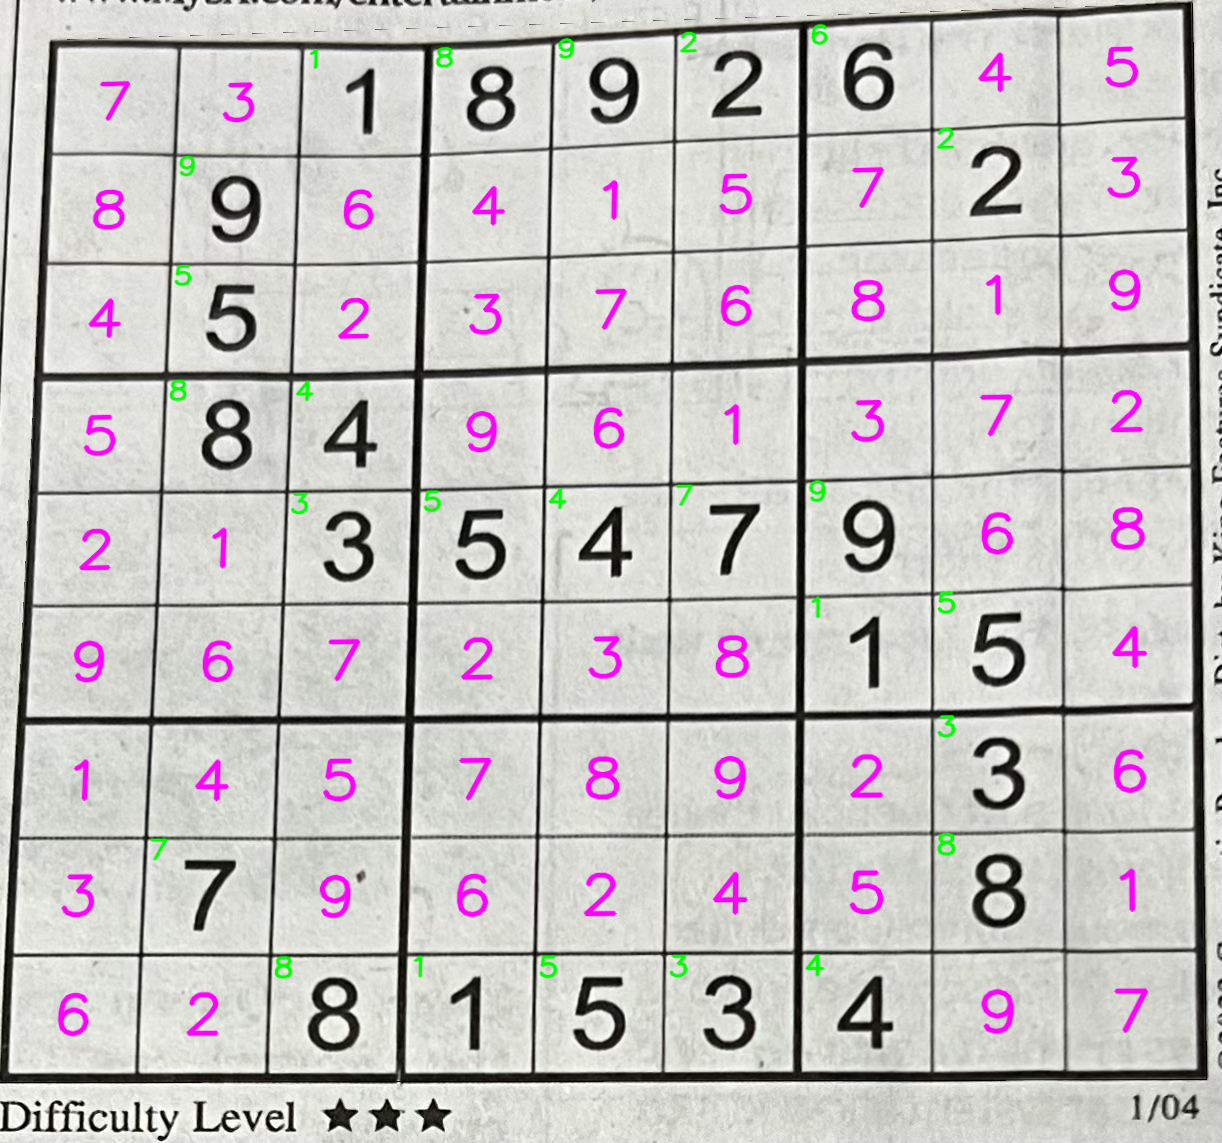

In [45]:
img_solved = put_board_on_image(img, board_points_on_image, board_solved)

cv2_imshow(img_solved)